In [1]:
## Updated 1-7-25


import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from skimage import io
import random
from joblib import load
import time
import unsupervised_scripts
import helper_scripts
from tkinter import Tk, filedialog


## Sample Directory (different for everyone)
data_dir = (input('Enter the path to your .tif hyperstacks: ').strip() or os.getcwd())


## Load Image
root = Tk()
root.withdraw()
root.call('wm', 'attributes', '.', '-topmost', True)
sample = filedialog.askopenfilename(initialdir=data_dir, multiple=True)
image = io.imread(sample[0])

indeces = [index for index, char in enumerate(sample[0]) if char=='/']
sample_name = sample[0][indeces[-1]+1:]

save_dir = 'D:/Shi_Lab/Spectral_Clustering/ML/output/'+sample_name+'/'
if os.path.exists(save_dir) is False:
  os.mkdir(save_dir)

## Remove NaNs and inf
image[np.isinf(image)] = 0
image[np.isnan(image)] = 0

## Vectorize Image
image_vec = np.reshape(image, (image.shape[0], image.shape[1]*image.shape[2]))
image_vec = image_vec.T

## Initialize start and end of hyperspectral sweep; num_samp is calculated from image stack
wavenum_1 = int(input('Enter first wavenumber/higher wavelength (Default=2700)): ').strip() or '2700')
wavenum_2 = int(input('Enter last wavenumber/lower wavelength (Default=3100): ').strip() or '3100')
num_samp = int(image_vec.shape[1])
ch_start = int(np.floor(num_samp/((wavenum_2-wavenum_1)/(2800-wavenum_1))))
background_df = pd.read_csv('water_HSI_76.csv')
molecule_df = pd.read_excel('lipid_subtype.xlsx')

### Semi-Supervised Learning

## Load artificial dataset
artificial_data = unsupervised_scripts.artificial_dataset(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
[mol_norm, mol_names] = artificial_data.molecule_dataset(molecule_df)

X_data = np.load('artificial_data/artificial_training_data-'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.npy')
Y_data = np.tile(np.array(range(mol_names.shape[0])), (X_data.shape[0], 1))
X = np.reshape(X_data, (X_data.shape[0] * X_data.shape[1], X_data.shape[2]))
Y = np.reshape(Y_data, (Y_data.shape[0] * Y_data.shape[1]))

## Process both datasets
preprocessing = unsupervised_scripts.preprocessing(wavenum_1, wavenum_2, num_samp, ch_start, background_df)
X_norm  = preprocessing.spectral_standardization(np.flip(X,axis=1))
image_norm = preprocessing.spectral_standardization(np.flip(image_vec,axis=1), br_shift=0)
save_input = helper_scripts.save_input()


(array([ 6060., 20630., 30220., 22360., 18860., 15440.,  9930.,  4750.,
         1310.,   440.]),
 array([0.        , 0.1126146 , 0.2252292 , 0.3378438 , 0.45045841,
        0.56307301, 0.67568761, 0.78830221, 0.90091681, 1.01353141,
        1.12614601]),
 <BarContainer object of 10 artists>)

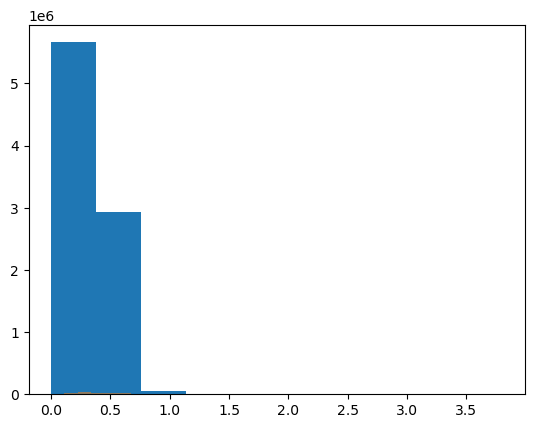

In [2]:
plt.hist(np.max(image_norm,axis=1)-image_norm[:,0])
plt.hist(np.max(X_norm,axis=1)-X_norm[:,0],alpha=0.5)

In [ ]:
## Save Normalized Image and channels (ONLY FOR 2700-3100)

# norm_image = np.reshape(image_norm, (image.shape[1],image.shape[2],image.shape[0]))
# norm_image = np.moveaxis(norm_image, 2, 0)
# io.imsave(save_dir+'normalized-'+sample_name, norm_image.astype('float32'))
# io.imsave(save_dir+'normalized-unsat-'+sample_name, np.max(norm_image[-12:-9],axis=0).astype('float32'))
# io.imsave(save_dir+'normalized-protein-'+sample_name, np.max(norm_image[-21:-18],axis=0).astype('float32'))
# io.imsave(save_dir+'normalized-sat-'+sample_name, np.max(norm_image[-25:-22],axis=0).astype('float32'))
# io.imsave(save_dir+'normalized-lipid-'+sample_name, np.max(norm_image[-28:25],axis=0).astype('float32'))

Text(0, 0.5, 'Normalized Intensity (A.U.)')

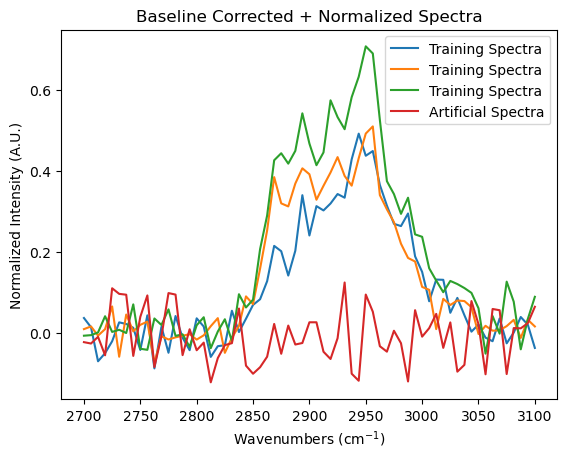

In [5]:
## Visualize random spectra for validation of preprocessing

wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
indeces = [random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1), random.randint(0,image_norm.shape[0]-1)]
plt.plot(wavenumbers, image_norm[indeces].T, label = 'Training Spectra')
plt.plot(wavenumbers, X_norm[np.random.randint(0,X_norm.shape[0])].T, label = 'Artificial Spectra')
plt.legend()
plt.title('Baseline Corrected + Normalized Spectra')
plt.xlabel('Wavenumbers (cm$^{-1}$)')
plt.ylabel('Normalized Intensity (A.U.)')

In [ ]:
# ## Optimize Smoothing of HSI and artificial spectra
# w = int(input('Enter window size for Savitzky-Golay smoothing (Default=6): ').strip() or '6')
# p = int(input('Enter polynomial for Savitzky-Golay smoothing (Default=3): ').strip() or '3')
# preprocessing.sav_gol_optimization(image_norm, w, p)
# preprocessing.sav_gol_optimization(X_norm, w, p)
# x = savgol_filter(image_norm,w,p, axis=1, mode='mirror')
# X = savgol_filter(X_norm,w,p, axis=1, mode='mirror')
# smooth = 'smoothing-'+str(w)+'-'+str(p)

In [4]:
## No smoothing (OPTIONAL)
x = image_norm
X = X_norm

smooth = 'No Smoothing'

c:\Users\jvill\anaconda3\envs\Shi\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\jvill\anaconda3\envs\Shi\Lib\site-packages\sklearn\base.py:347: InconsistentVersionWarning: Trying to unpickle estimator RandomForestClassifier from version 1.5.0 when using version 1.3.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy Score: 0.9927179487179487


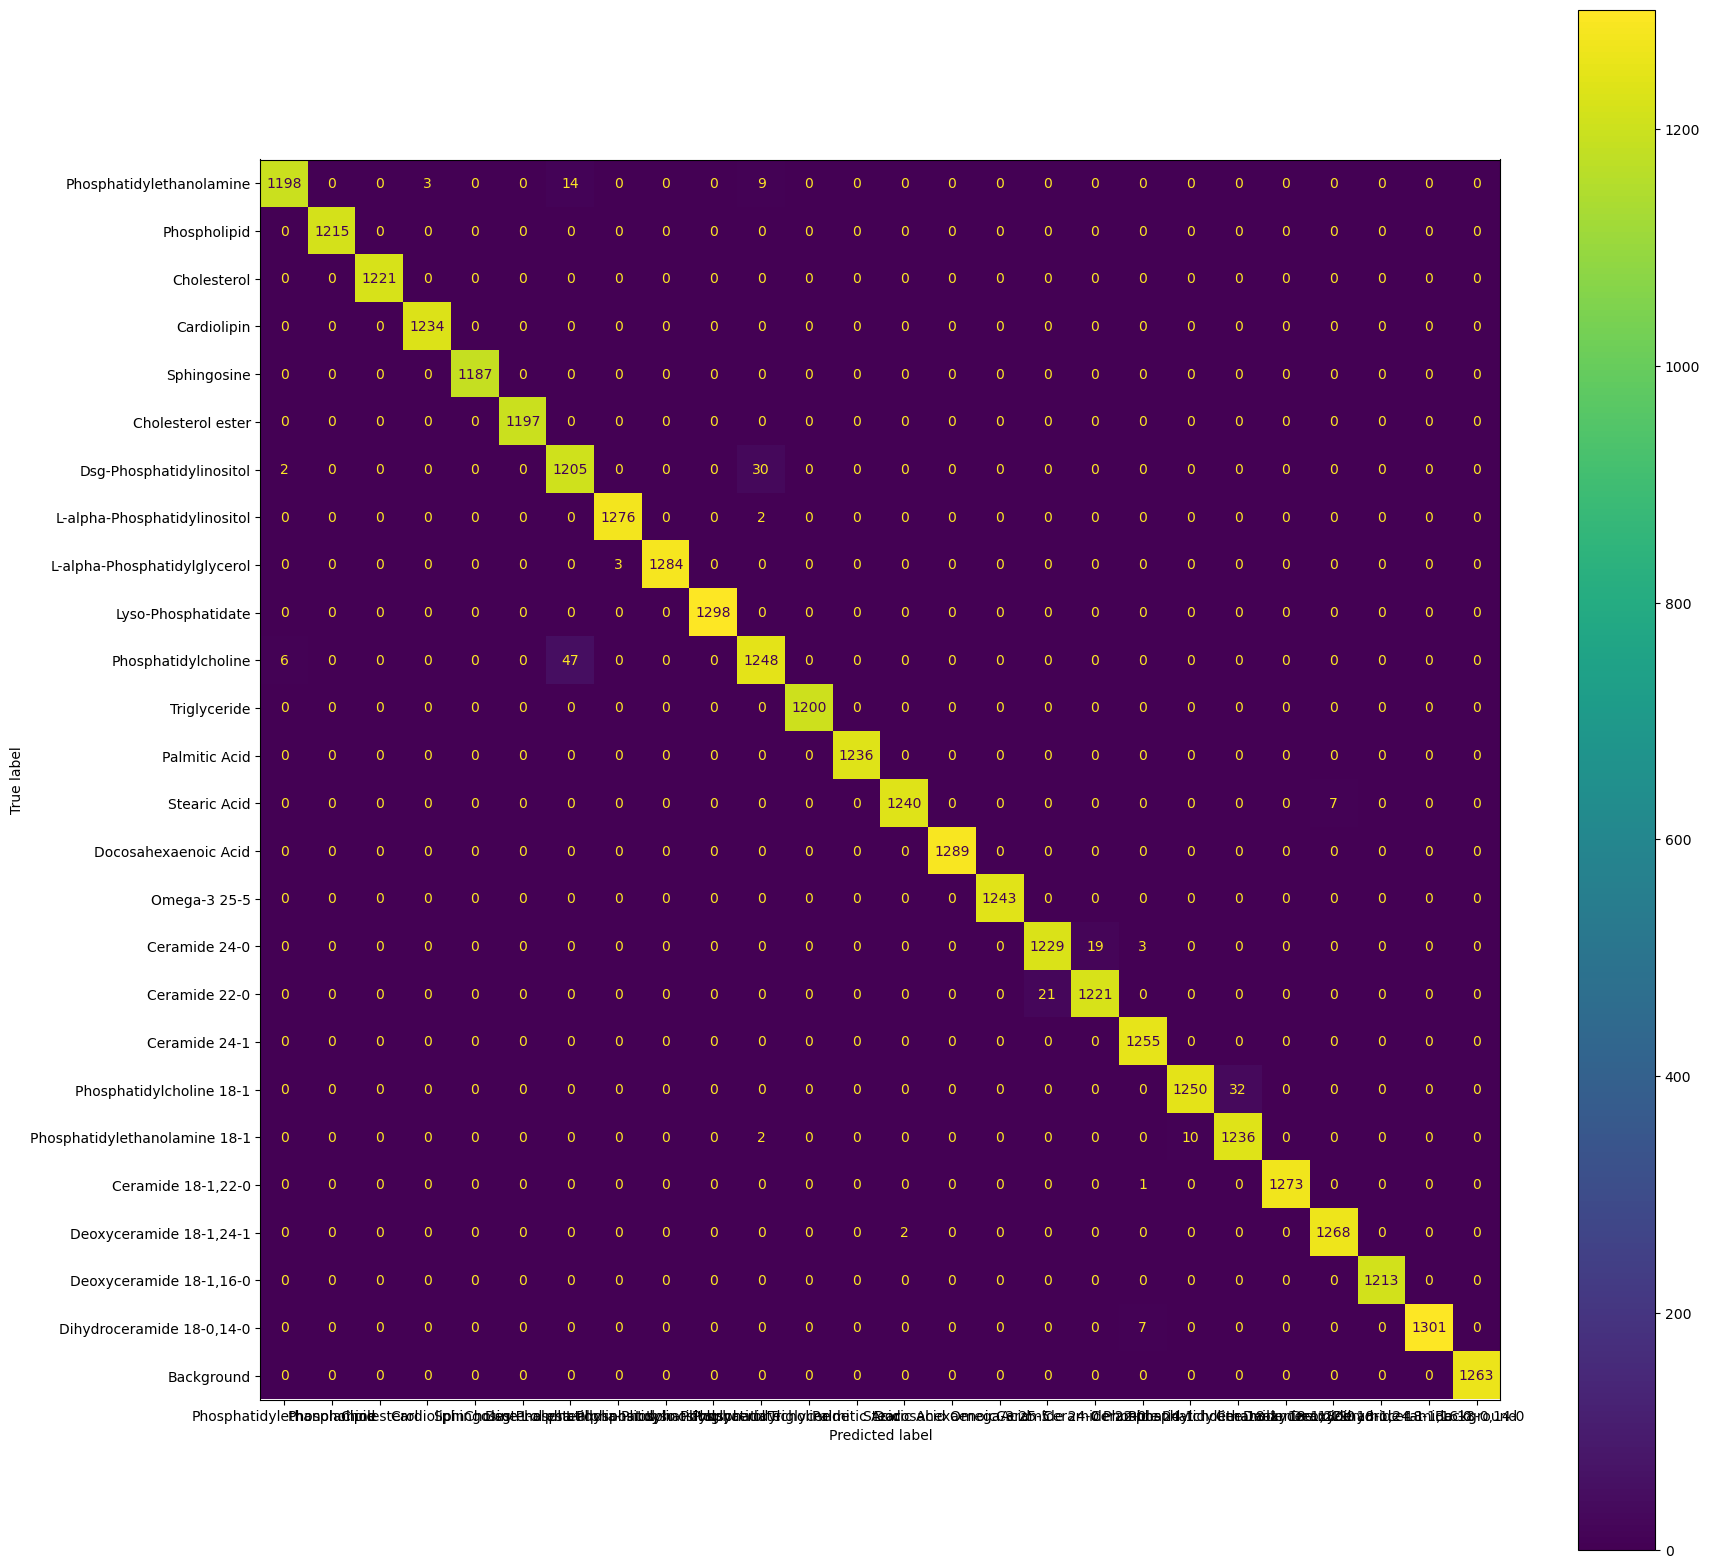

In [7]:
## Random Forest Classification
rf_classifier = unsupervised_scripts.RF_classify(x, X, Y, .25)
num_estimators =250
rfc = load('rf_classifiers/rfc-'+smooth+'_'+str(wavenum_1)+'_'+str(wavenum_2)+'_'+str(num_samp)+'.joblib')
print('Accuracy Score: ' + str(rfc.score(rf_classifier.X_train, rf_classifier.y_train)))
rf_classifier.confusion_matrix(mol_names, rfc)

In [8]:
## USe Random Forest Classifier on Unlabeled HSI
start_time = time.time()
outputs = unsupervised_scripts.semi_supervised_outputs(x, mol_names, rfc)
end_time = time.time()
execution_time = end_time - start_time
print(f"Execution time: {execution_time} seconds")

Execution time: 72.07630062103271 seconds


100%|██████████| 25/25 [00:01<00:00, 17.34it/s]


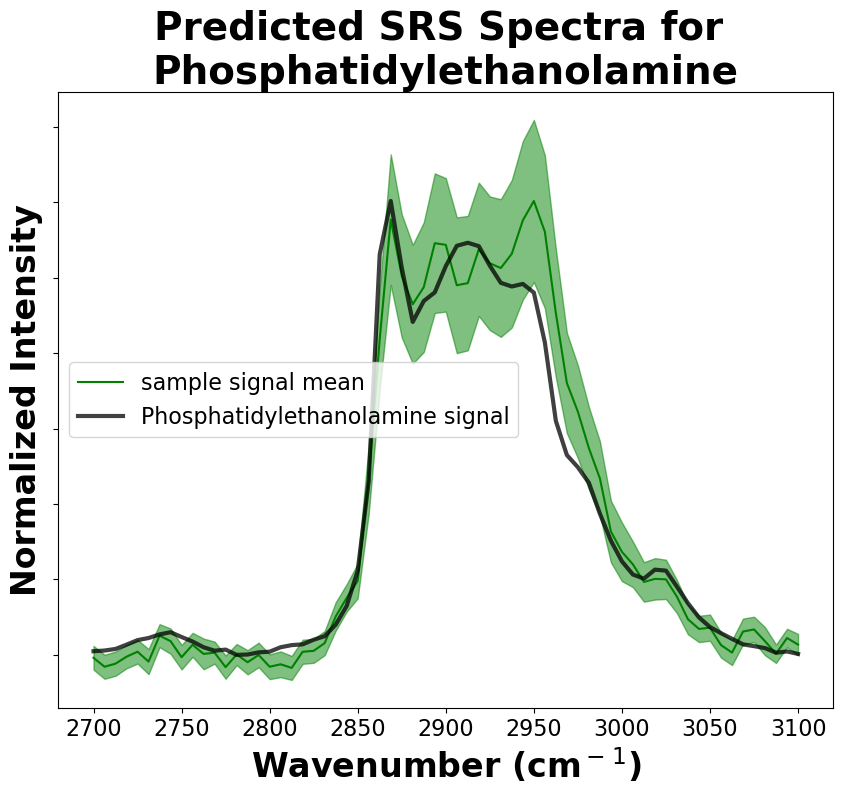

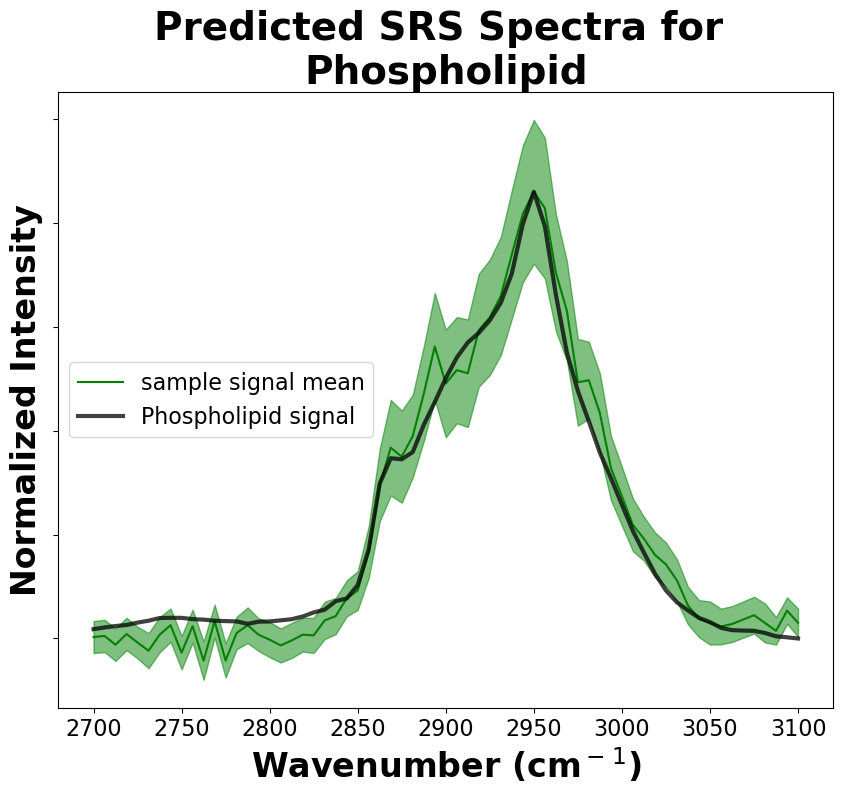

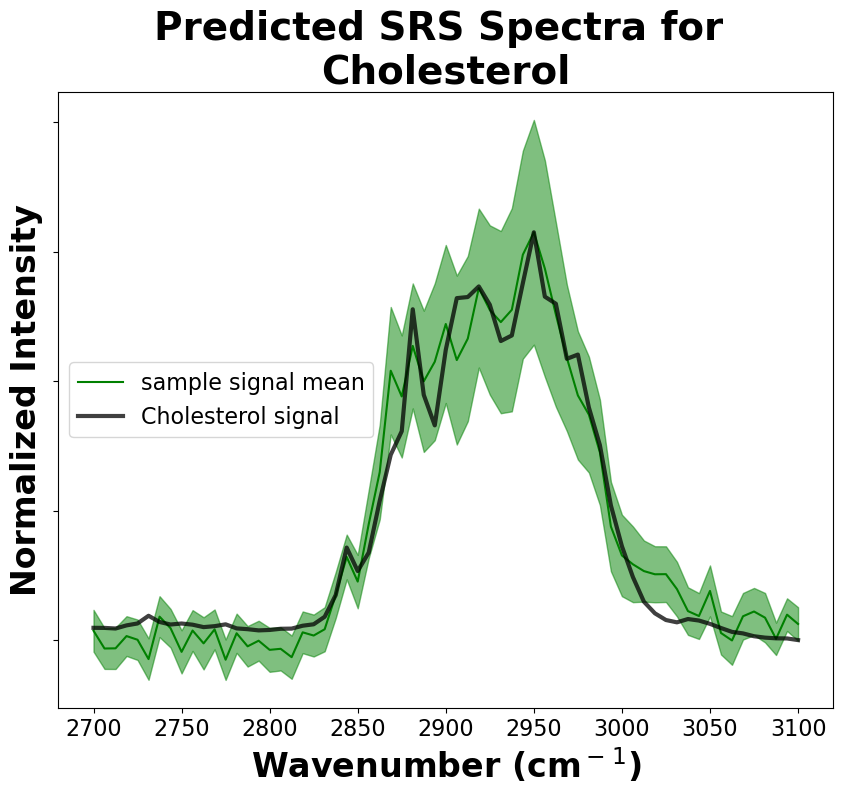

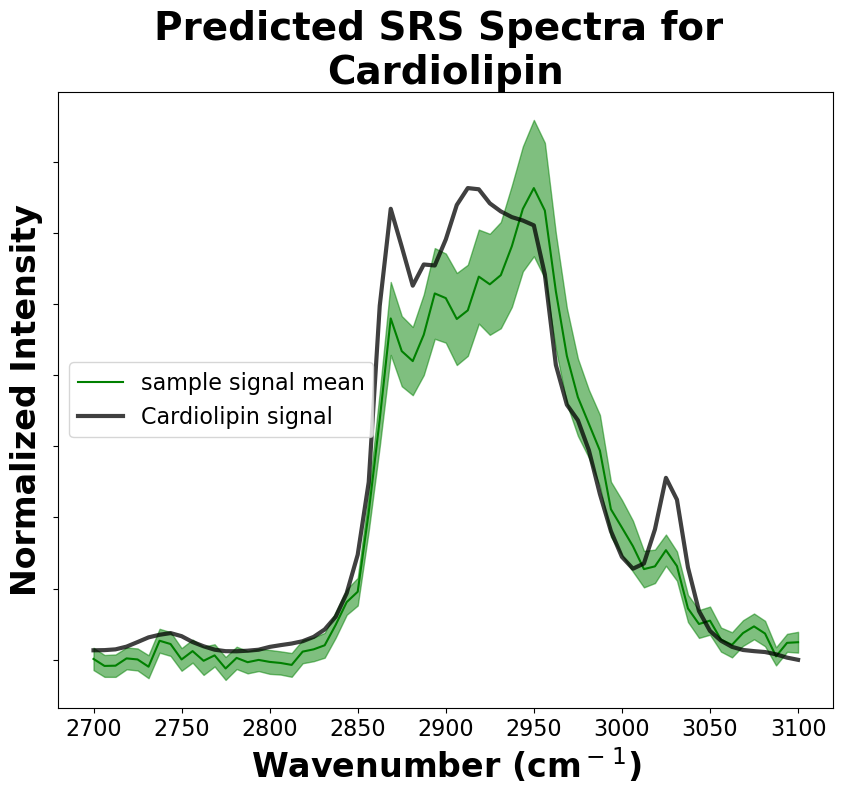

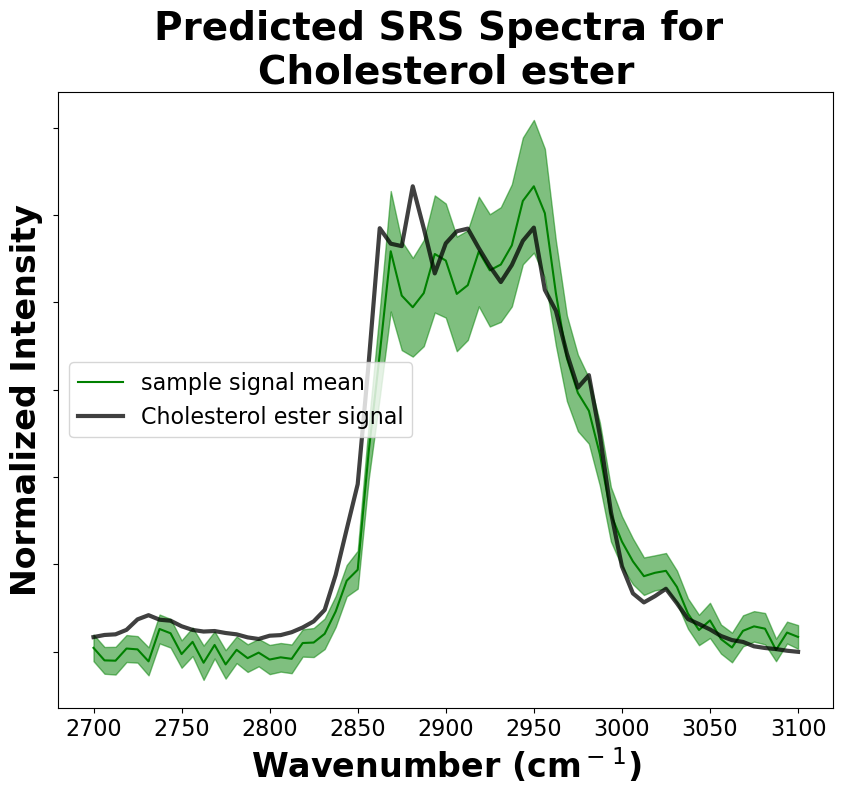

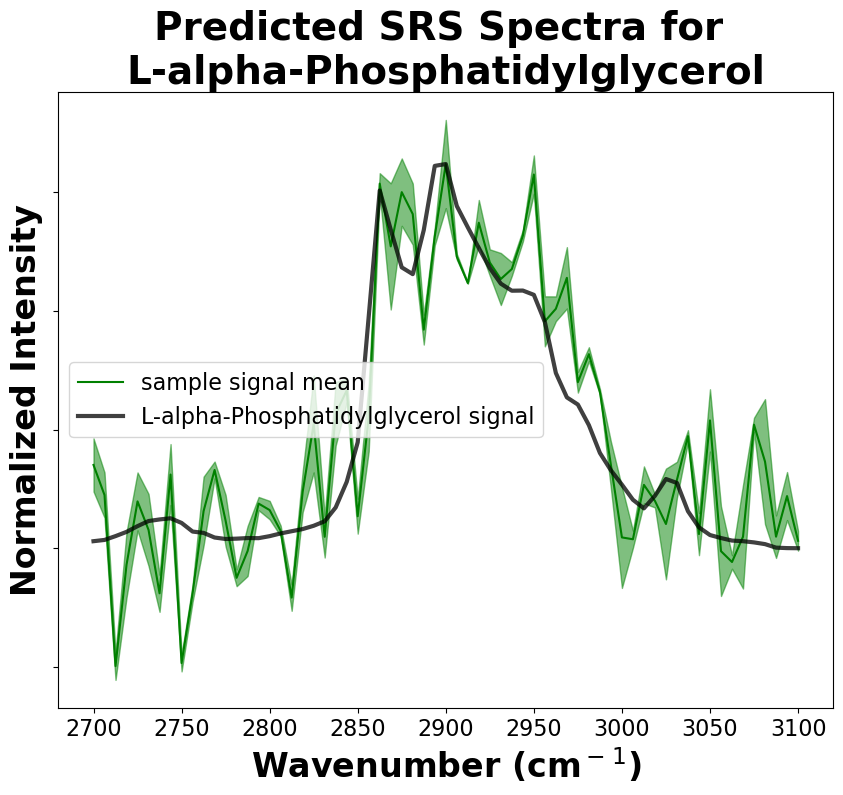

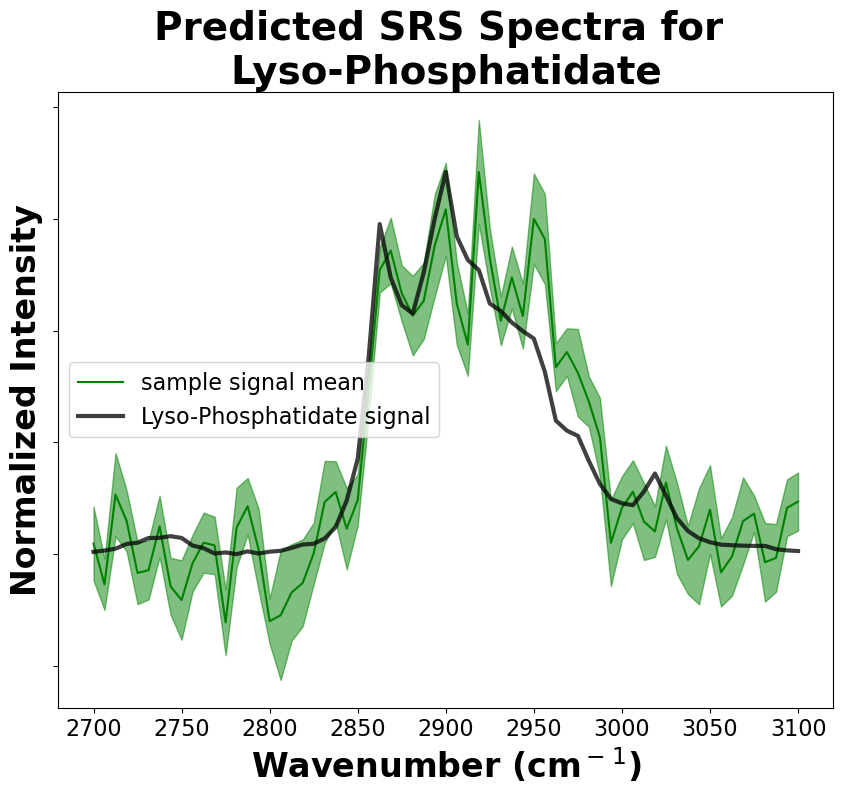

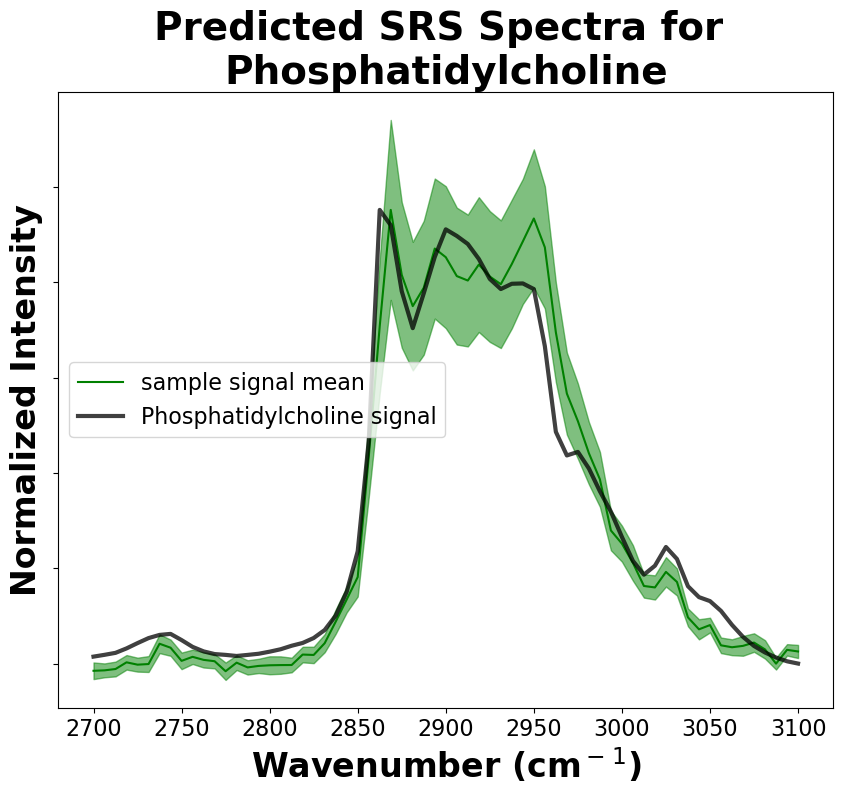

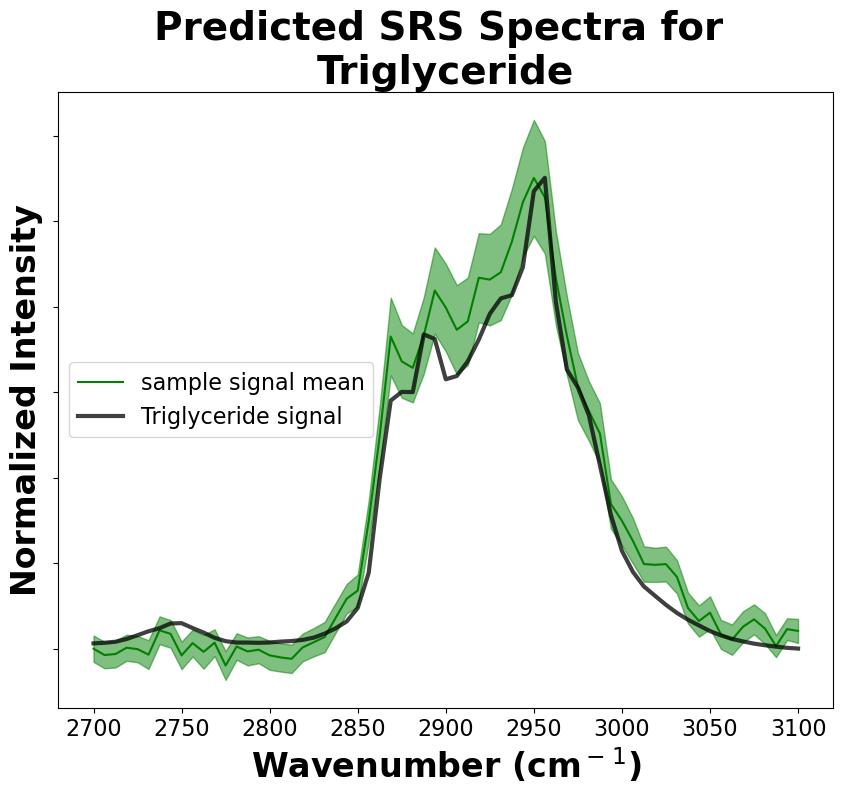

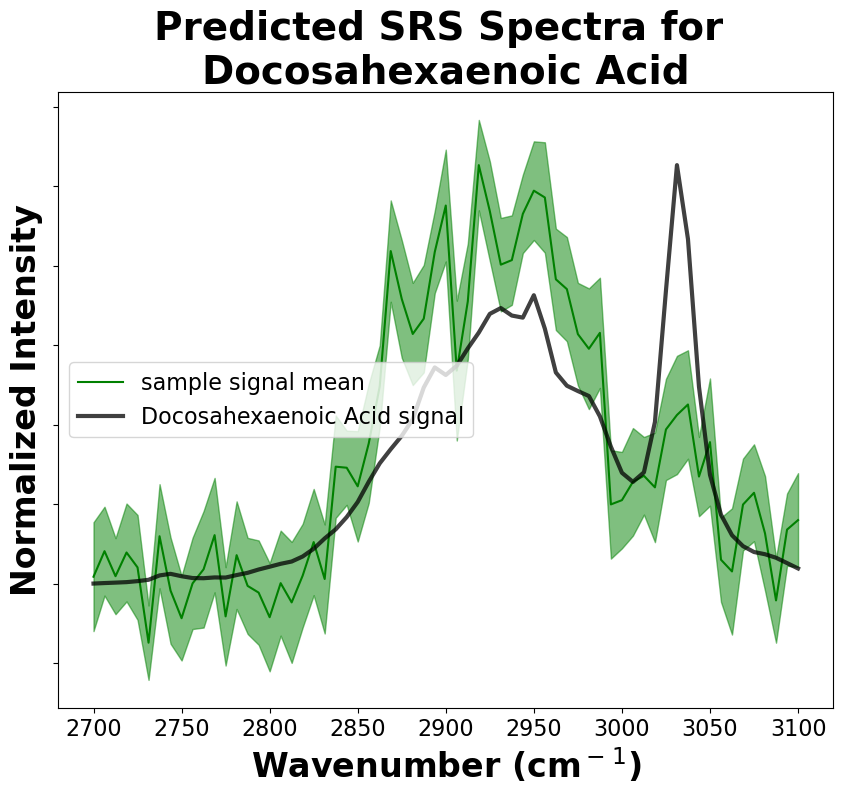

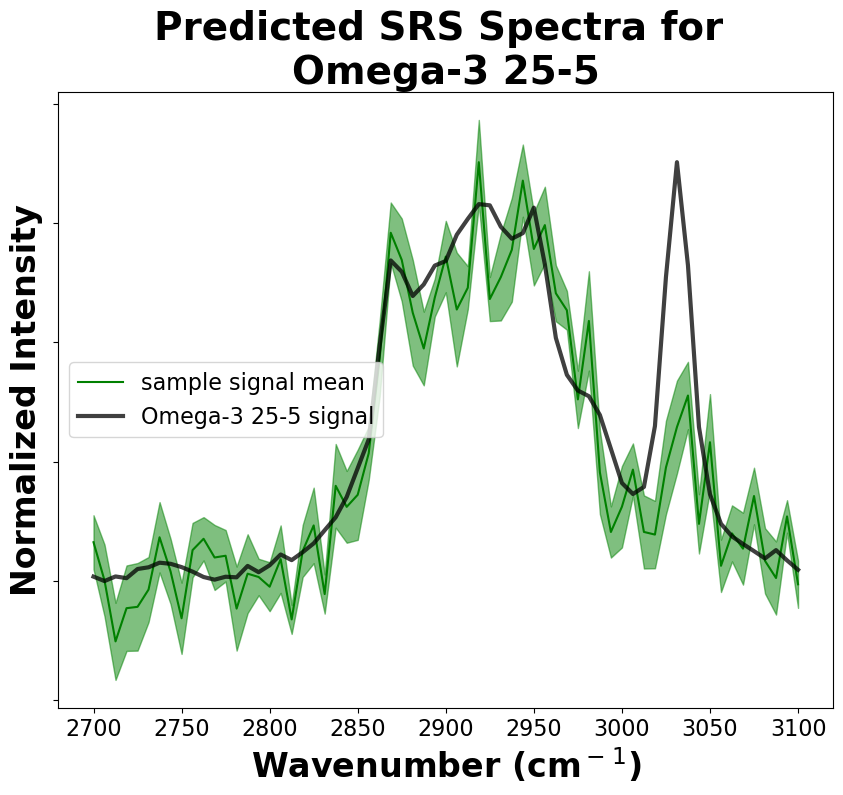

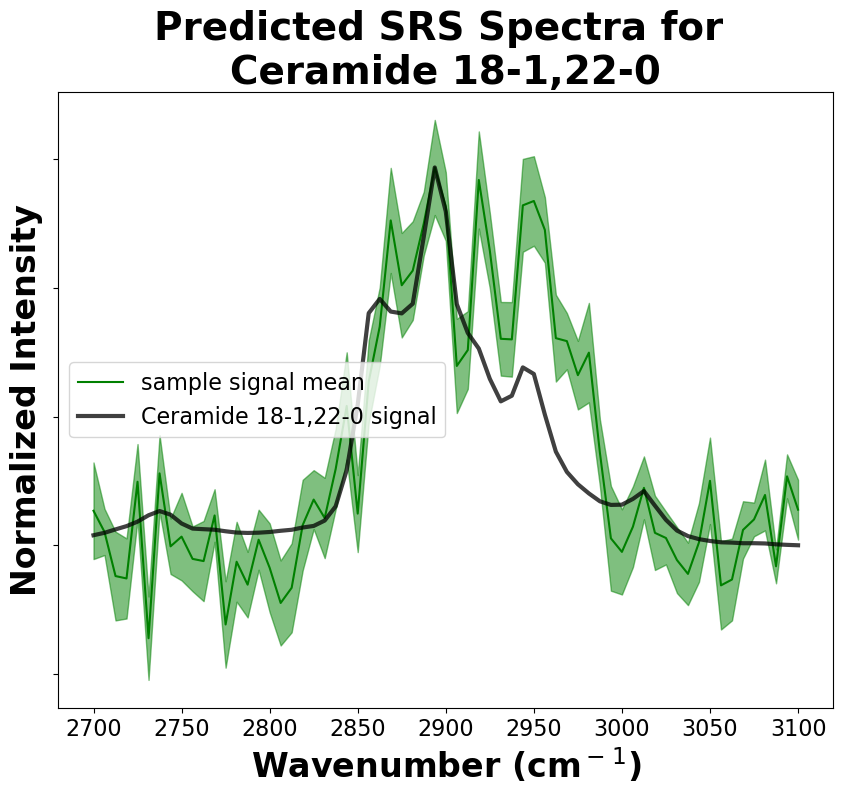

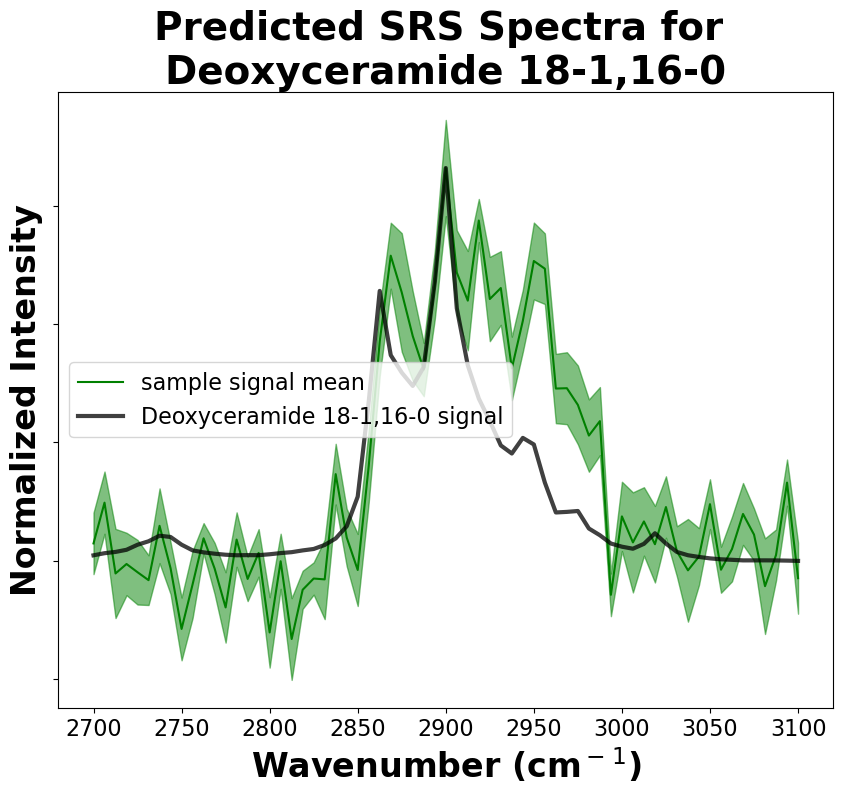

In [9]:
## Spectral Graphs
# save_input = helper_scripts.save_input()
wavenumbers = np.linspace(wavenum_1, wavenum_2, num_samp)
outputs.spectral_graphs(mol_norm, wavenumbers, save_input, save_dir)
outputs.probability_images(image, save_input, save_dir)

In [10]:
import helper_scripts
print('Save similarity metric .csv?')
ave_input = helper_scripts.save_input()
outputs.similarity_metrics(mol_norm, save_input, save_dir)

Save similarity metric .csv?


100%|██████████| 265/265 [00:00<00:00, 519.47it/s]


The MSE for Phosphatidylethanolamine is: 0.011076381742134595
The Cosine Similarity for Phosphatidylethanolamine is: 0.9863250957607348
The Cross-Correlation for Phosphatidylethanolamine is: 0.986325118061924


100%|██████████| 70360/70360 [02:15<00:00, 519.49it/s]


The MSE for Phospholipid is: 0.010983268725934595
The Cosine Similarity for Phospholipid is: 0.9864503732905474
The Cross-Correlation for Phospholipid is: 0.9864503427268855


100%|██████████| 1314/1314 [00:02<00:00, 522.84it/s]


The MSE for Cholesterol is: 0.004806670173352075
The Cosine Similarity for Cholesterol is: 0.9744921957950613
The Cross-Correlation for Cholesterol is: 0.977834821420436


100%|██████████| 7367/7367 [00:14<00:00, 509.32it/s]


The MSE for Cardiolipin is: 0.00532252329140754
The Cosine Similarity for Cardiolipin is: 0.9793900663661192
The Cross-Correlation for Cardiolipin is: 0.9794288167630696


100%|██████████| 3664/3664 [00:07<00:00, 482.27it/s]


The MSE for Cholesterol ester is: 0.003556562279749718
The Cosine Similarity for Cholesterol ester is: 0.975916020455045
The Cross-Correlation for Cholesterol ester is: 0.9840095246850956


100%|██████████| 2/2 [00:00<00:00, 400.32it/s]


The MSE for L-alpha-Phosphatidylglycerol is: 0.0010301718195747918
The Cosine Similarity for L-alpha-Phosphatidylglycerol is: 0.9017056391642837
The Cross-Correlation for L-alpha-Phosphatidylglycerol is: 0.901705641612274


100%|██████████| 10/10 [00:00<00:00, 416.65it/s]


The MSE for Lyso-Phosphatidate is: 0.001245451117952883
The Cosine Similarity for Lyso-Phosphatidate is: 0.8641685472704069
The Cross-Correlation for Lyso-Phosphatidate is: 0.871870111465611


100%|██████████| 73/73 [00:00<00:00, 439.03it/s]


The MSE for Phosphatidylcholine is: 0.02115650064859273
The Cosine Similarity for Phosphatidylcholine is: 0.9860305513322947
The Cross-Correlation for Phosphatidylcholine is: 0.9860305756380415


 35%|███▌      | 62770/177414 [01:58<03:35, 531.59it/s]


KeyboardInterrupt: 